In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, glob
import pandas as pd
from random import shuffle
from sklearn.datasets import load_files       
from keras.utils import np_utils

%matplotlib inline

from pyke import kepdraw, kepstitch, kepflatten, kepfold, keptrial, kepperiodogram, keprange, kepbls
from pyke.lightcurve import KeplerLightCurveFile, KeplerQualityFlags


Using TensorFlow backend.
D:\Anaconda2\envs\deeplearning-gpu\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Exploring the Data

Using PyKE, I am loading the fits file for Kepler ID: 11442793 after it has been stitched and normalized.  The SAP_FLUX lines are representative of the brightness for each of the quarters that were stitched together.  The SAP_FLUX data is before the raw data before the normalization process.

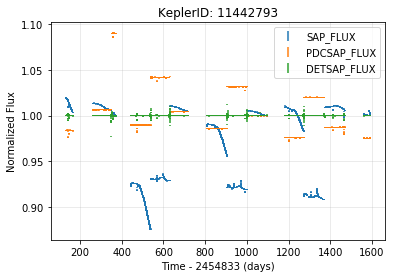

In [11]:
klc=KeplerLightCurveFile('k90-kepstitch-kepflatten.fits', quality_bitmask=KeplerQualityFlags.DEFAULT_BITMASK)
klc.plot()

# Visualizing the Preprocessed CNN Input
After the fits file was normalized, a new data point is added called DETSAP_FLUX.  Using this, I graphed its value against the time.  I reduced the boundary of the brightness on the y-axis to capture the majority of the data.  In the image above, this is the green line (DETSAP_FLUX).  Using matplotlib, I graphed the values to help illustrate the change in brightness for this star.  

This star has 8 planets per the NASA Validation Report which can be found here:
https://archive.stsci.edu/missions/kepler/dv_files/0114/011442793/kplr011442793-20160209194854_dvr.pdf


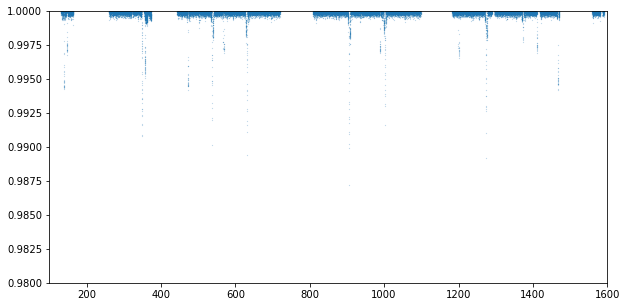

In [12]:
sap_lc = klc.get_lightcurve('DETSAP_FLUX')
plt.figure(figsize=[10, 5])
plt.scatter(sap_lc.time, sap_lc.flux, s=0.01)
plt.ylim([.98,1.0])
plt.xlim([100,1600])
plt.grid(False)

The data validation report indicates that one planet has an orbit of approximately 331 days.  The first time it transits in front of the star is on day 141 and then again on day 472.
The next two transits should occur on day 803 and day 1134, but during these times, the Kepler telescope did not capture any data

![k90_p1_zoomed.png](notebook_images/k90_p1_zoomed.png)

# Data Acquisition and Preprocessing

I downloaded all the wget scripts for false positives by quarter from:
http://archive.stsci.edu/missions/kepler/lightcurves/tarfiles/wget_scripts/.
Each quarter of data has been saved to /false_positives/q{i} where i is from 0 to 17.

The exoplanet source data originated from http://archive.stsci.edu/missions/kepler/lightcurves/tarfiles/Exoplanet_KOI/.  For this dataset, I only used the long cadence tgz files and extracted them to their respective quarter folders.
/exoplanet/q{i} where i is from 0 to 17.

Using PYKE from https://github.com/KeplerGO/pyke, I called the kepstitch function.  The kepstitch requires an input array of fits files orderd by quarter.  For example, an array for a kepler object across quarter 0,1,2 would look like:
['k123_q0.fits', 'k123_q1.fits', 'k123_q2.fits']

I created a dictionary that contains the kepler id for the key, and a string array of the fits file as described above.  Looping through the dictionary, I was then able to stitch all false positives that I had data for.  The same process was done for the kepler targets that had planet candidates.

In [2]:
#build EXOPLANET dictionary array.  
#Each entry contains the kepler id with a value that has an array of the 
#fits file for the kepler id per quarter
PREPROCESSED = True
if not PREPROCESSED:
    keplerid_withexoplanets_dictionary = {}
    for i in range(0,18):    #loop through q0-q17"
        path = 'D:\kepler data\exoplanet\Exoplanet_KOI_Q'+str(i)+'_long\KOI_Q'+str(i)+'_long'    
        os.chdir(path)
        for file in glob.glob("*.fits"):
            kid = file.split('-')[0]
            if kid in keplerid_withexoplanets_dictionary:
                keplerid_withexoplanets_dictionary[kid].append(path + '\\' + file)                       
            else:
                files = []
                files.append(path + '\\' + file) 
                keplerid_withexoplanets_dictionary[kid] = files
    

In [100]:
#build FALSE POSITIVE dictionary array.  
#Each entry contains the kepler id with a value that has an array of the 
#fits file for the kepler id per quarter
if not PREPROCESSED:
    keplerid_falsepositives_dictionary = {}
    for i in range(0,18):    #loop through q0-q17
        path = 'D:\\kepler data\\false_positives\\q'+str(i)   
        os.chdir(path)
        for file in glob.glob("*.fits"):
            kid = file.split('-')[0]
            if kid in keplerid_falsepositives_dictionary:
                keplerid_falsepositives_dictionary[kid].append(path + '\\' + file)                       
            else:
                files = []
                files.append(path + '\\' + file) 
                keplerid_falsepositives_dictionary[kid] = files


In [101]:
def quarterstitch(kid, input_array, dest):    
    #print(kepler_id)
    output_file = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\'+ dest +'\\' + kid + '-kepstitch.fits'
    print(output_file)
    kepstitch(input_array, outfile=output_file, overwrite=True)
    return output_file, kid

In [3]:
#this will quarterstitch the exoplanets from the newly created dictionaries
if not PREPROCESSED:
    for key, value in keplerid_withexoplanets_dictionary.items():
        quarterstitch(key, value, output_stitch)      
    

In [103]:
#this will quarterstitch the false positives
if not PREPROCESSED:
    for key, value in keplerid_falsepositives_dictionary.items():
        quarterstitch(key, value, 'output_stitch_falsepositives')      
    

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001026957-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001026957-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001293031-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001293031-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001430305-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001430305-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001571511-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr001571511-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004472818-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004472818-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004544628-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004544628-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004545926-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004545926-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004568117-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004568117-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005955621-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005955621-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005956787-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005956787-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005963222-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005963222-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005964985-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005964985-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007532973-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007532973-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007584650-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007584650-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007601633-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007601633-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007684873-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007684873-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008738244-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008738244-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008757910-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008757910-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008780959-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008780959-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008801343-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008801343-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010089911-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010089911-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010125352-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010125352-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010139390-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010139390-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010140843-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010140843-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011671429-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011671429-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011769801-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011769801-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011804437-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011804437-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011820830-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011820830-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002860114-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002860114-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002860793-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002860793-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002970804-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002970804-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002972800-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr002972800-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003548639-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003548639-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003550434-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003550434-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003556220-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003556220-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003557493-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr003557493-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004076976-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004076976-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004077901-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004077901-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004150539-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004150539-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004150624-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004150624-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004852297-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004852297-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004858610-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004858610-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004860932-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004860932-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004861527-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004861527-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005303551-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005303551-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005305404-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005305404-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005305471-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005305471-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005306383-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005306383-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005598595-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005598595-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005607631-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005607631-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005608566-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005608566-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005618071-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr005618071-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006182849-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006182849-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006185496-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006185496-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006185711-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006185711-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006199702-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006199702-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006610064-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006610064-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006612327-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006612327-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006620003-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006620003-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006629993-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006629993-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007117549-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007117549-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007124026-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007124026-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007132542-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007132542-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007136729-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007136729-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007820699-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007820699-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007830637-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007830637-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007837302-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007837302-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007837733-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007837733-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008349405-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008349405-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008358012-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008358012-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008365739-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008365739-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008374580-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008374580-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008868649-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008868649-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008868907-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008868907-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008869680-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008869680-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008883727-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008883727-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009394768-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009394768-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009396760-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009396760-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009406892-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009406892-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009412445-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009412445-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009823564-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009823564-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009834719-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009834719-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009838608-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009838608-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009838975-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009838975-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010152836-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010152836-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010153827-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010153827-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010156055-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010156055-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010157573-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010157573-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010585738-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010585738-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010587105-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010587105-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010599397-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010599397-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010601465-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010601465-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011298815-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011298815-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011303815-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011303815-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011304987-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011304987-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011305996-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011305996-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012316431-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012316431-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012407623-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012407623-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012418891-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012418891-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012459725-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr012459725-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006863161-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006863161-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006864885-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006864885-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006891637-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006891637-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007021177-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr007021177-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010619142-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010619142-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010651945-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010651945-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010661778-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010661778-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010857342-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr010857342-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004275739-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004275739-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004356766-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004356766-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004372768-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004372768-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004391348-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr004391348-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006227560-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006227560-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006292162-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006292162-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006359802-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006359802-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006364067-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr006364067-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008495415-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008495415-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008543279-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008543279-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008560285-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008560285-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008625813-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008625813-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011709423-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011709423-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011752908-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011752908-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011913013-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011913013-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011968463-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr011968463-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008780968-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr008780968-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009366988-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009366988-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009468384-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009468384-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009593759-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009593759-kepstitch.fits...
D:\pdaskas\u

D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009784230-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009784230-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009886224-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009886224-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009896435-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009896435-kepstitch.fits...
D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009957351-kepstitch.fits
Writing output file D:\pdaskas\udacity\machine-learning\projects\capstone\output_stitch_falsepositives\kplr009957351-kepstitch.fits...
D:\pdaskas\u

After stitching together all the quarter data for each kepler id, I had to normalize the data.  I was able to do this with the use of PyKE's kepflatten function.  

Running this process across 4 cores on my cpu took about 5 days running non-stop.  The script I wrote for this can be found in the scripts folder.  It is named stitch-and-flatten.py.

The contents of the cell are also shown in the next cell.

In [14]:
if not PREPROCESSED:

    from multiprocessing import Process
    import threading
    import time
    import os
    import glob

    from pyke import kepdraw, kepstitch, kepflatten, kepfold, keptrial, kepperiodogram, keprange, kepbls
    from pyke import KeplerLightCurveFile, KeplerQualityFlags

    stitch_path = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\output_stitch'    
    flatten_destination = 'D:\pdaskas\\udacity\\machine-learning\\projects\\capstone\\output_stitch_flatten\\'
    os.chdir(stitch_path)

    def f(file):
        file_name = file.split('.')[0]
        kepflatten(file, outfile=flatten_destination + file_name + '-kepflatten.fits', overwrite=True)

    if __name__ == '__main__':
        for file in glob.glob("*.fits"):
            p = Process(target=f, args=(file,))
            p.start()
            p.join()

# Data Sanitization

I acquired a list of vetted planet candidates and false positives from the NASA Exoplanet Archive and used the list to identify any mislabeled fits file that had been created.  Doing this required comparing the kepler id in the list to the kepler id extracted from the fits file that had been flattened.  


In [5]:
#https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=q1_q17_dr25_koi
#https://exoplanetarchive.ipac.caltech.edu/docs/PurposeOfKOITable.html#q1-q17dr25
if not PREPROCESSED:
    data = pd.read_csv("D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\vetted\\q1_q17_dr25_koi_candidates.csv", delimiter = ",")
    data_fp = pd.read_csv("D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\vetted\\q1_q17_dr25_koi_falsepositives.csv", delimiter = ",")
    not_vetted = []
    vetted_as_candidate = []
    vetted_as_falsepositive = []
    def check_against_vetted(kepid):
        if(kepid in data.kepid.values):          
            vetted_as_candidate.append(kepid)
        elif(kepid in data_fp.kepid.values):
            vetted_as_falsepositive.append(kepid)
        else: 
            not_vetted.append(kepid)
   



In [6]:
if not PREPROCESSED:
    path = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\output_stitch_flatten'    
    os.chdir(path)
    for file in glob.glob("*.fits"):
        klc=KeplerLightCurveFile(file, quality_bitmask=KeplerQualityFlags.DEFAULT_BITMASK)
        sap_lc = klc.get_lightcurve('DETSAP_FLUX')    
        check_against_vetted(sap_lc.keplerid)


# Generating the Inputs

When createing the images, I leveraged the new lists (vetted_as_candidate and vetted_as_falsepositive) to create image files  and save them to a false positive or planet candidate folder.  Classifying the data in this manner was necessary for model training using Keras' ImageDataGenerator.flow_from_directory function.

In [4]:
IMAGES_CREATED = True
PROCESS_FP = True

def create_images(path):   
    os.chdir(path)    
    for file in glob.glob("*.fits"):
        klc=KeplerLightCurveFile(file, quality_bitmask=KeplerQualityFlags.DEFAULT_BITMASK)
        sap_lc = klc.get_lightcurve('DETSAP_FLUX')
        if not PROCESS_FP:
            if sap_lc.keplerid in vetted_as_falsepositive:
                img_file_loc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\false_positives\\'
            if sap_lc.keplerid in vetted_as_candidate:
                img_file_loc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\planet_candidates\\'
            if sap_lc.keplerid in not_vetted:
                img_file_loc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\unknown\\'
        else:
            img_file_loc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\false_positives\\'
        img_file = str(sap_lc.keplerid) + '.png'
        
        if (not os.path.exists(img_file_loc + img_file)):
            plt.figure(figsize=[50, 6])
            plt.scatter(sap_lc.time, sap_lc.flux, s=0.1)
            plt.ylim([.98,1.0])
            plt.xlim([100,1600])
            plt.grid(False)


            plt.savefig(img_file_loc + img_file)
            plt.clf()
            plt.cla()
            plt.close()

In [7]:
path_fp = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\output_stitch_falsepositives_flatten'  
path_o = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\output_stitch_flatten'  
if not IMAGES_CREATED:
    create_images(path_fp)
    create_images(path_o)

## Data Split and Shuffle

I created a function to split and shuffle the png files.  The training set is 80% of the data for each class.  Within the training set, I used 33% of the data for the validation set for each class.  Finally, the remaining 20% of the total for each class was used for the test set.

In [37]:
SHUFFLED = True
fp = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\false_positives\\'
train_fp = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\train\\false_positives\\'
test_fp = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\test\\false_positives\\'
valid_fp = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\valid\\false_positives\\'

pc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\planet_candidates\\'
train_pc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\train\\planet_candidates\\'
test_pc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\test\\planet_candidates\\'
valid_pc = 'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\valid\\planet_candidates\\'

def shuffle_move(path, train, test, valid):
    os.chdir(path)    
    files =  glob.glob("*.png")
    shuffle(files)
    train_size = int(len(files) * 0.8)
    valid_size = int(train_size* 0.33) #this should be 33% of train_size
    train_size = train_size - valid_size
    test_size = int(len(files) * 0.2) #this should be 20%
    for i, file in enumerate(files):    
        if i <= train_size:        
            os.rename(path + file, train + file)
        elif i > train_size and i <= train_size+valid_size:
            os.rename(path + file, test + file)
        else:
            os.rename(path + file, valid + file)

In [38]:
#shuffle the false positives
if not SHUFFLED:
    shuffle_move(fp, train_fp, test_fp, valid_fp)

In [69]:
#shuffle the planet candidates
if not SHUFFLED:
    shuffle_move(pc, train_pc, test_pc, valid_pc)

# Keras ImageDataGenerator Configuration

Initially my png files were 432 x 3600.  I wanted a higher resolution to capture the details as the graph for each kepler id contained roughly 70000 points.  Due to memory constraints on the GPU (6GB memory), I was forced to scale down the image.  

Using the ImageDataGenerator class, I set the target_size to be 216x1800 and set my batch size to 4.  I set the color_mode to grayscale, as color is not relevant in the images.  The only relevant features are datapoints.

In [9]:
from keras.preprocessing.image import ImageDataGenerator
import os, glob

#image dimensions
height = 216
width = 1800
batchsize = 4

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\train\\',
        target_size=(height, width),
        batch_size=batchsize,
        class_mode='categorical',
        color_mode='grayscale')#,
        #save_to_dir='D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\saved\\')

validation_generator = valid_datagen.flow_from_directory(
        'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\valid\\',
        target_size=(height, width),
        batch_size=batchsize,
        class_mode='categorical',
        color_mode='grayscale')
        

test_generator = test_datagen.flow_from_directory(
        'D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\images\\test\\',
        target_size=(height, width),
        batch_size=batchsize,
        class_mode='categorical',
        color_mode='grayscale',
        shuffle=True)


Found 2425 images belonging to 2 classes.
Found 1112 images belonging to 2 classes.
Found 885 images belonging to 2 classes.


# Benchark Model - Vanilla CNN

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv2D(16, 3, input_shape=(height, width, 1), activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 214, 1798, 16)     160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 212, 1796, 64)     9280      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 9,570
Trainable params: 9,570
Non-trainable params: 0
_________________________________________________________________


## Compile Benchark Model

In [26]:
#using adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Benchmark Model

In [36]:
from keras.callbacks import ModelCheckpoint  
epochs = 75

checkpointer = ModelCheckpoint(filepath='D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\saved_models\\weights.best.from_scratch.hdf5', verbose=0, save_best_only=True)

#hist = model.fit(train_tensors, train_targets, 
#          validation_data=(valid_tensors, valid_targets),
#          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

#https://keras.io/models/model/
#steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch 
#finished and starting the next epoch. It should typically be equal to the number of samples of your dataset divided 
#by the batch size. Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
start_time = time.time()

hist = model.fit_generator(
        train_generator,
        steps_per_epoch=int(2425/batchsize),  #2425 are the number of training images
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(1112/batchsize), #1112 are the number of validation images
        callbacks = [checkpointer],
        verbose = 2
)

end_time = time.time()
print(end_time - start_time)

Epoch 1/75
119s - loss: 0.6921 - acc: 0.5281 - val_loss: 0.6922 - val_acc: 0.5054
Epoch 2/75
116s - loss: 0.6906 - acc: 0.5276 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 3/75
114s - loss: 0.6889 - acc: 0.5272 - val_loss: 0.6888 - val_acc: 0.5144
Epoch 4/75
115s - loss: 0.6864 - acc: 0.5417 - val_loss: 0.6874 - val_acc: 0.5351
Epoch 5/75
111s - loss: 0.6810 - acc: 0.5813 - val_loss: 0.6869 - val_acc: 0.5459
Epoch 6/75
110s - loss: 0.6809 - acc: 0.5862 - val_loss: 0.6811 - val_acc: 0.5836
Epoch 7/75
111s - loss: 0.6742 - acc: 0.6044 - val_loss: 0.6816 - val_acc: 0.5647
Epoch 8/75
111s - loss: 0.6720 - acc: 0.5912 - val_loss: 0.6753 - val_acc: 0.5863
Epoch 9/75
112s - loss: 0.6688 - acc: 0.6023 - val_loss: 0.6754 - val_acc: 0.5692
Epoch 10/75
112s - loss: 0.6645 - acc: 0.6114 - val_loss: 0.6677 - val_acc: 0.6070
Epoch 11/75
110s - loss: 0.6633 - acc: 0.6081 - val_loss: 0.6675 - val_acc: 0.5917
Epoch 12/75
110s - loss: 0.6567 - acc: 0.6172 - val_loss: 0.6744 - val_acc: 0.5683
Epoch 13/75
1

## Calculate Metrics for Benchmark Model

In [37]:
model.load_weights('D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\saved_models\\weights.best.from_scratch.hdf5')

In [38]:
score = model.evaluate_generator(test_generator, int(885/batchsize))

In [39]:
print(model.metrics_names)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1]*100)

['loss', 'acc']
Test loss:  0.149363686879
Test accuracy:  99.2054483541


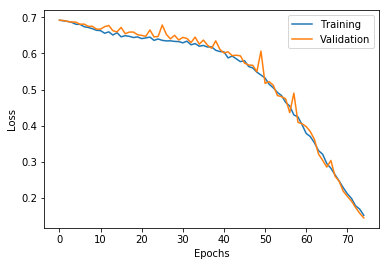

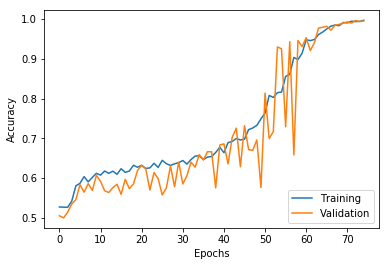

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

# Adding more Layers to the CNN

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model_e = Sequential()
model_e.add(Conv2D(32, 3, input_shape=(height, width, 1), activation='relu'))
model_e.add(Conv2D(64, 3,  activation='relu'))
model_e.add(Conv2D(128, 3, activation='relu'))
model_e.add(GlobalAveragePooling2D())
model_e.add(Dense(2, activation='softmax'))

model_e.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 214, 1798, 32)     320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 212, 1796, 64)     18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 210, 1794, 128)    73856     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 92,930
Trainable params: 92,930
Non-trainable params: 0
_________________________________________________________________


## Compile and Train

In [5]:
from keras.optimizers import Adam

model_e.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 20


checkpointer = ModelCheckpoint(filepath='D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\saved_models\\weights.best.hdf5', verbose=0, save_best_only=True)

#hist = model_e.fit(train_tensors, train_targets, 
#          validation_data=(valid_tensors, valid_targets),
#          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

#https://keras.io/models/model/
#steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch 
#finished and starting the next epoch. It should typically be equal to the number of samples of your dataset divided 
#by the batch size. Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.

hist_optimized = model_e.fit_generator(
        train_generator,
        steps_per_epoch=int(2425/batchsize),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(1112/batchsize),
        callbacks = [checkpointer]
)

Epoch 1/20
606/606 [==============================] - 324s - loss: 0.6932 - acc: 0.5144 - val_loss: 0.6930 - val_acc: 0.5072
Epoch 2/20
606/606 [==============================] - 317s - loss: 0.6930 - acc: 0.5264 - val_loss: 0.6935 - val_acc: 0.5036
Epoch 3/20
606/606 [==============================] - 317s - loss: 0.6924 - acc: 0.5252 - val_loss: 0.6930 - val_acc: 0.5081
Epoch 4/20
606/606 [==============================] - 319s - loss: 0.6923 - acc: 0.5272 - val_loss: 0.6928 - val_acc: 0.5135
Epoch 5/20
606/606 [==============================] - 319s - loss: 0.6922 - acc: 0.5256 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 6/20
606/606 [==============================] - 318s - loss: 0.6875 - acc: 0.5351 - val_loss: 0.6877 - val_acc: 0.4973
Epoch 7/20
606/606 [==============================] - 308s - loss: 0.6829 - acc: 0.5776 - val_loss: 0.6856 - val_acc: 0.5764
Epoch 8/20
606/606 [==============================] - 311s - loss: 0.6758 - acc: 0.5928 - val_loss: 0.6770 - val_acc: 0.5899


## Calculate Metrics

Evaluating the model performance against my test data showed an interesting result. The test accuracy reached 100%.  Perhaps this is a a result of insufficient data.  If my training model identified a set of features, and my validation data always had a subset of the features, then this would support the 100% validation accuracy.  The same case exists for the test set.  To build a more robust model would require a larger set of data, or better image resolution.  Because of hardware constraints, I was forced to reduce the resolution of my images, making it harder for the CNN to detect more patterns in the images.

Test loss:  0.00739517527089
Test accuracy:  100.0


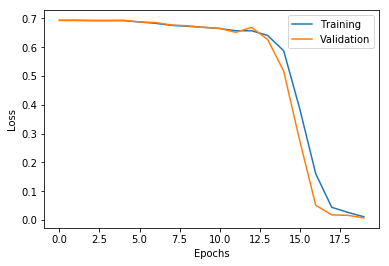

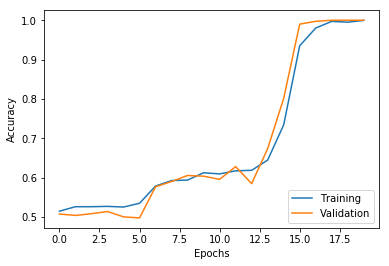

In [6]:
model_e.load_weights('D:\\pdaskas\\udacity\\machine-learning\\projects\\capstone\\saved_models\\weights.best.hdf5')

score = model_e.evaluate_generator(test_generator, int(885/batchsize))
print('Test loss: ', score[0])
print('Test accuracy: ', score[1]*100)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist_optimized.history['loss'])
plt.plot(hist_optimized.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist_optimized.history['acc'])
plt.plot(hist_optimized.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')